In [26]:
## Import packages

# basic
import pandas as pd
import numpy as np
import gower
import pickle
from datetime import date
from math import prod

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

# text processing
from collections import Counter
from sklearn.feature_extraction import _stop_words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup

# modelling 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import catboost
# 7 popular regression models
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge, SGDRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
# validation metrics 
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carolinesofieljorring/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carolinesofieljorring/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Technical Report

## Introduction and description of data


In this project, we would like to make recommendations to Amazon in order to improve their products and thereby their sales. The aim is to identify features of high rated products and 


- intro til problem 
- intro til data: ratings, metadata 
- 


In this project we are working with Amazon data. We want to give Amazon an insight to their inventory of food and groceries products with high rating and investigate if they have specific features which contribute to their high rating. 



We will carry out this investigation with various machine learning techniques like LDA topic modelling, regression analysis and machine learning interoperability in order to find features which can give low rated products better ratings.




## Data preparation
Data and preprocessing:
In this project we will use two datasets. The first dataset contains ratings for groceries and gourmet foods and the second contains relevant information of the products. Both datasets are loaded with a function we call "CreateData". 

In [3]:
### Import raw data
def load_data(rating_filepath, review_filepath, metadata_filepath):
    ratings_df = pd.read_csv(rating_filepath, names = ['item','user','rating','timestamp'])
    reviews_df = pd.read_json(review_filepath, lines=True)
    metadata_df = pd.read_json(metadata_filepath, lines=True)
    return ratings_df, reviews_df, metadata_df

Then a preparation of the data is performed with the function "prepare_data". The purpose of this function is to merge the datasets and to structure the data. In the function we group on each item and we find the average rating, standard deviation of rating and the number of ratings for each item. 
The "category" feature is originally a list of categories with "Grocery and Gourmet Food" as the first element followed by multiple subcategories. Hence we change "category" so it only contains the second element of the list corresponding to the largest subcategory after the main category "Grocery and Gourmet Food".

In [4]:
### Function for preparing the data
def prepare_data(ratings_df, reviews_df, metadata_df):
    # create timestamps
    ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], origin = 'unix', unit = 's')
    reviews_df['timestamp'] = pd.to_datetime(reviews_df['unixReviewTime'], origin = 'unix', unit = 's')
    metadata_df['timestamp'] = pd.to_datetime(metadata_df['date'].apply(str), format = '%B %d, %Y', errors='coerce')

    # drop columns in reviews
    reviews_df = reviews_df.drop(columns=['unixReviewTime','reviewTime','reviewerName','vote','image','style','verified'])

    # drop columns in metadata
    metadata_df = metadata_df.drop(columns=['imageURL','imageURLHighRes'])
    
    # drop na's and duplicates
    reviews_df = reviews_df.dropna()
    reviews_df = reviews_df.drop_duplicates(keep='first')
    ratings_df = ratings_df.drop_duplicates(keep='first')

    # group ratings_df and merge with metadata, so there is one dataframe with both ratings and information of products
    grouped_ratings = ratings_df[['item','rating']].groupby(by='item').agg({'rating':['mean','std'],'item':'size'}).rename(columns={'statistics':'avg_rating','item':'num_ratings'}).reset_index()
    grouped_ratings.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped_ratings.columns.values]
    grouped_ratings = grouped_ratings.rename(columns = {'rating_mean':'avg_rating','rating_std':'std_rating','num_ratings_size':'num_ratings'})
    metadata_df = grouped_ratings.merge(metadata_df, how='outer', left_on='item', right_on='asin')
    metadata_df['item'].fillna(metadata_df['asin'], inplace=True)
    metadata_df = metadata_df.drop(columns=['asin','date','tech1','tech2','fit'])

    # preprocess price
    metadata_df['price'] =  pd.to_numeric(metadata_df['price'].str.replace('$',''), errors='coerce')

    # Fill nan with empty space and use the get_category function
    metadata_df['category'] = metadata_df['category'].fillna('')
    metadata_df['category'] = metadata_df['category'].apply(get_category)
    
    return reviews_df, metadata_df

# Function to return only the first name in each category variable.
def get_category(row):
    if len(row) > 1:
        category = row[1]
    else:
        category = row
    return category


After the data is merged we save it as a new csv file.

In [5]:
rating_filepath = 'raw_data/Grocery_and_Gourmet_Food.csv'
review_filepath = 'raw_data/Grocery_and_Gourmet_Food_5.json' 
metadata_filepath = 'raw_data/meta_Grocery_and_Gourmet_Food.json'

raw_ratings, raw_reviews, raw_metadata = load_data(rating_filepath=rating_filepath, review_filepath=review_filepath, metadata_filepath=metadata_filepath)

reviews_df, metadata_df = prepare_data(raw_ratings, raw_reviews, raw_metadata)

# Save the new dataframes to later use. 
reviews_df.to_csv('data/reviews_df.csv',index=False)
metadata_df.to_csv('data/metadata_df.csv',index=False)

/var/folders/fs/z4lysv996dq1_bqqn9qzfwch0000gn/T/ipykernel_38216/3781916918.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  metadata_df['price'] =  pd.to_numeric(metadata_df['price'].str.replace('$',''), errors='coerce')


## Data Exploration
The idea behind our investigation is to find features of high rated products and recommend to add the features to low rated products. However, if the products are too different like chocolate and apples it does not make sense to compare features for these products even if one has a high rating and the other a low rating. Therefore, we analyze the data by looking at the different product categories and explore the number of products, the number of ratings and variance in the average rating of the products. It is important for our analysis that we have categories with both many products and many ratings. However it is also important that we have something to improve, meaning we need categories with some variances in the average rating of products. We will only be looking at the top 20 categories in the exploration. 

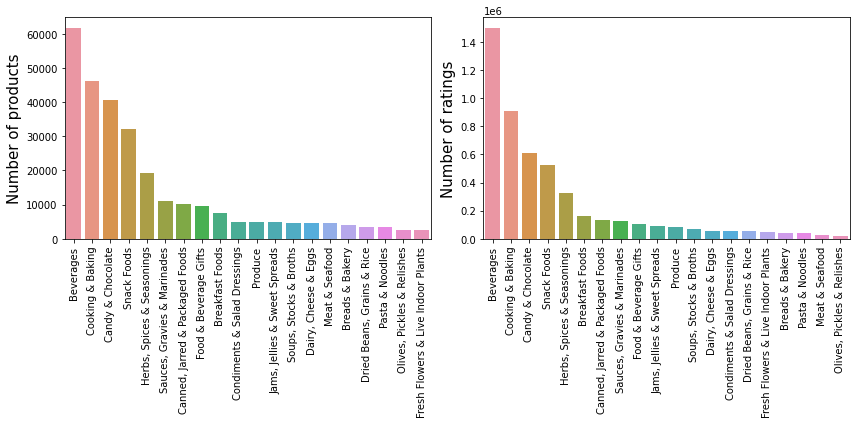

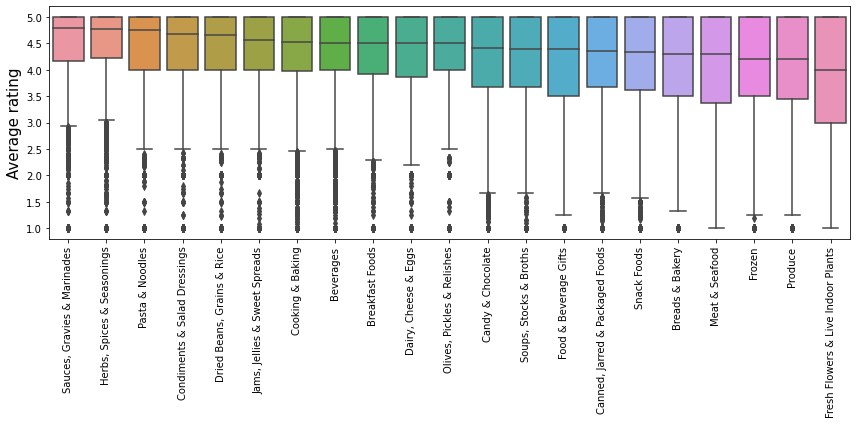

In [21]:
# lead data 
df = pd.read_csv('data/metadata_df.csv')

# Number of products in each category
def get_category(row, categories):
    if row in categories:
        return row
    else:
        return ''

# We will only look at the top 20 categories
top = 20
categories = df['category'].value_counts().sort_values(ascending=False).index[0:top].to_list()

# Copy the dataframe
df_category = df.copy(deep=True)

# Return number of products in each category
df_category['category'] = df_category['category'].apply(lambda row: get_category(row, categories))
df_category = df_category[df_category['category'] != '']

# Number of ratings in each category
df_num_ratings = df[['category','num_ratings']].groupby(by=["category"]).sum(["num_ratings"])
df_num_ratings = df_num_ratings['num_ratings'].sort_values(ascending=False).reset_index()

# Plot of the number of productts in each category and the number of ratings in each category
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x="category", data=df_category, order=categories, ax=ax1)
ax1.set_ylabel('Number of products', fontsize=15)
ax1.set_xlabel('')
ax1.set_xticklabels(categories,rotation=90)
sns.barplot(x="category", y="num_ratings", data=df_num_ratings[0:top], ax=ax2)
ax2.set_ylabel('Number of ratings', fontsize=15)
ax2.set_xlabel('')
ax2.set_xticklabels(df_num_ratings.loc[0:(top-1),'category'].to_list(),rotation=90)
fig.tight_layout()
fig.show()

# Plot with variance of average ratings in each category 
categories_union = list(set().union(categories,df_num_ratings.loc[0:top,'category'])) # list of categories shown in figure 1 and 2
df_mean_avg_rating = df[df['category'].isin(categories_union)].groupby('category').median(['avg_rating']).sort_values(by='avg_rating',ascending=False)
categories_union = df_mean_avg_rating.index.to_list()
plt.figure(2, figsize=(12,6))
sns.boxplot(x = 'category', y = 'avg_rating', data = df[df['category'].isin(categories_union)], order = categories_union)
plt.xticks(rotation=90)
plt.ylabel('Average rating', fontsize=15)
plt.xlabel('')
plt.tight_layout()
plt.show()

By investigating the plot with number of ratings and number of products we find "Beverages", "Cooking & Baking", "Candy & Chocolate" and "Snack Foods" are the categories with most in both. When we compare these categories with the boxplot showing the variance of the average rating, both "Snack Foods" and "Candy & Chocolate" have a decent spread. "Beverages" and "Cooking & Baking" almost have the same median and spread, but "Beverages" has both more products and ratings and we therefore only use "Beverages" as a category along with "Candy & Chocolate" and "Snack Foods". 

These three categories are then saved as csv file separetily. 

In [7]:
# Select category 
category = 'Snack Foods'
df_cat = df[df['category']==category]

# Save dataframe for category 
df_cat.to_csv('data/'+category+'/df_'+category+'.csv',index=False)

## Data preprocessing
So far we have found 3 categories we want to use for our hypothesis and saved them as separate dataframes. These 3 datasets needs to be further processed before we can use them for modelling. In the function "preprocess_price" we are splitting our datasets into a training set and a test set. A lot of products in the three catgories are missing price. To overcome this issue and still be able to use price as a feature in the modelling, the missing price values in each category are replaced with the average price of the category.

In [8]:
# Function for preprocessing the prize where the data also will splitted in a train and a test set. 
def preprocess_price(metadata_df):
    # Drop columns we don't use
    df = metadata_df.drop(columns = ['item','title','feature','main_cat','similar_item','details','timestamp'])
    # Empty columns can't be used for anything
    df = df.dropna(axis=0,subset=['avg_rating','num_ratings','description'])
    # Split the data in a 75 % split train and test set. 
    df_train, df_test = train_test_split(df, train_size=0.75)

    # Below we find the mean price for every cateogry. 
    categories = []
    category_means = []
    categories = df_train.category.unique()
    for i in categories:
        temp = df_train[df_train['price'].isna() == False]
        mean_value = temp[temp['category'] == i]['price'].mean()
        category_means.append(mean_value)
    dict = {'categories': categories,'category_means': category_means}
    category_stat_df = pd.DataFrame(dict)
    category_stat_df = category_stat_df.set_index('categories')

    # Next for all NULL values we assign the price to be the mean price in that category.
    df_train['price'] = df_train.apply(lambda row: category_stat_df.loc[row['category']].values[0] if row['price'] != row['price'] else row['price'], axis = 1)
    df_test['price'] = df_test.apply(lambda row: category_stat_df.loc[row['category']].values[0] if row['price'] != row['price'] else row['price'], axis = 1)
    
    # Here we drop the category column. 
    columns = df_train.columns
    if 'category' in columns:
        df_train = df_train.drop(columns = ['category'])
        df_test = df_test.drop(columns = ['category'])
    if 'orig category' in columns:
        df_train = df_train.drop(columns = ['orig category'])
        df_test = df_test.drop(columns = ['orig category'])
    return df_train, df_test

The training set and the test set are now further processed in the "preprocess_data" function where the features are cleaned and prepared for modelling. 

In the function we clean the features "also_buy", "also_view", "rank" and "description". For each product, the two features "also_buy" and "also_view" contain a list of other products that are often bought or viewed together with the product. These features are converted to a count. For the feature "rank", which contains the sales rank information of the products, all characters are removed besides the sales rank number which is converted to an integer value. 

In the "description" feauture we clean text from html code, remove punctuation and stop words etc. When removing stop words from "description" we only use the English stop words. However when we later on perform LDA on the data we observe there are words that either occur in multiple topics or doesn't make sense in the topic, and therefore we add them to stop words for the specific category. 

In [9]:
# Function to preprocess the train and test dataset
def preprocess_data(df_train, df_test):
    # get number of also_buy
    df_train['also_buy'] = df_train['also_buy'].fillna('').apply(get_number_also_buy)
    df_test['also_buy'] = df_test['also_buy'].fillna('').apply(get_number_also_buy)

    # get number of also_view
    df_train['also_view'] = df_train['also_view'].fillna('').apply(get_number_also_buy)
    df_test['also_view'] = df_test['also_view'].fillna('').apply(get_number_also_buy)

    # sales rank information
    df_train['rank'] = df_train['rank'].apply(get_rank).str.replace(',','').str.extract('(\d+|$)')
    df_train['rank'] = pd.to_numeric(df_train['rank'], errors = 'coerce').fillna(0).apply(int)
    df_test['rank'] = df_test['rank'].apply(get_rank).str.replace(',','').str.extract('(\d+|$)')
    df_test['rank'] = pd.to_numeric(df_test['rank'], errors = 'coerce').fillna(0).apply(int)

    # Clean description
    df_train['description'] = df_train['description'].apply(get_description)
    # Drop rows with no information
    df_train = df_train.dropna(axis = 0, subset=['description'])
    # Make it a string and clean html text
    df_train['description'] = df_train['description'].apply(str)
    df_train['description'] = df_train['description'].str.replace('\n', '')
    df_train['description'] = df_train[['description']].applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    # Perform text processing where stop words are removed etc. 
    df_train['description'] = df_train['description'].apply(text_processing)

    # Do the same for test dataset
    df_test['description'] = df_test['description'].apply(get_description)
    df_test = df_test.dropna(axis = 0, subset=['description'])
    df_test['description'] = df_test['description'].apply(str)
    df_test['description'] = df_test['description'].str.replace('\n', '')
    df_test['description'] = df_test[['description']].applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    df_test['description'] = df_test['description'].apply(text_processing)
    return df_train, df_test
    
# Number of also bougtht products
def get_number_also_buy(row):
    number = len(row)
    return number
# Get the brand
def get_brand(row, brands):
    if row in brands:
        return row
    else:
        return 'Other'
# Get the rank from list
def get_rank(row):
    if isinstance(row, list):
        if len(row) > 0:
            return row[0]
        else:
            return ''
    else:
        return row

# Use only rows with list of information else nan
def get_description(row):
    if isinstance(row, list):
        if len(row)>0:
            return row
        else:
            return np.nan
    else:
        return row

# Function used to clean text data
def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
        if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    # remove stopwords
    text = " ".join([w for w in text.split() 
        if w not in Stop_Words])
    return text
    # Words from already trained lda model. The words are removed because they either occur in multiple topics or doesn't make sense in the topic. 

category = 'Snack Foods'
if category == 'Candy & Chocolate':
    Stop_Words = _stop_words.ENGLISH_STOP_WORDS.union(['chocolate','supplement','cocoa','candy','cure','condition'])
elif category == 'Snack Foods':
    Stop_Words = _stop_words.ENGLISH_STOP_WORDS.union(['snack','food','fda','flavor','product','ingredient','statement'])
elif category == 'Beverages':
    Stop_Words = _stop_words.ENGLISH_STOP_WORDS.union(['tea','coffee','water','cup','supplement','flavor','year','food','condition'])

<!-- Kjær læse igennem -->
The training and test set are now almost fully processed, but we still need to handle categorical data. The "brand" feature contains almost 15000 different brands and it would not make any sense to create dummy data for som many categories. We will therefore perform a principle components analysis and create clusters with the brands, so we have numerical data we can use for modelling. 

In [22]:
# First we read the "prepared" data and the proper category found in the "exploratory part"
metadata_df = pd.read_csv('data/'+category+'/df_'+category+'.csv')

#We clone the category, as we will need this in order to preprocess price, but we will remove the original category column, 
# when we create dummy data
metadata_df['orig category'] = metadata_df['category']
dummy_df = pd.get_dummies(metadata_df, columns=['brand','orig category'])
# We drop brand as we can't have non numerical values. 
metadata_df = metadata_df.drop(columns=['brand'])

# We apply the preprocess price function, which handles some of the preprocess functions as well as splits the data in train and test.
df_train, df_test = preprocess_price(metadata_df)
df_train_dummy, df_test_dummy = preprocess_price(dummy_df)

# Next the second part of the preprocess will be applied.
df_train, df_test = preprocess_data(df_train, df_test)
df_train_dummy, df_test_dummy = preprocess_data(df_train_dummy, df_test_dummy)

## We drop description when we do pca on the data as it is non-numerical. Also we drop std_rating as it is quite hightly correlated with 
# Avg. rating, and it seems unlikely that std_rating can be gathered in a situation where average rating (the target) can't.
df_train_dummy = df_train_dummy.drop(columns = ['description','std_rating'])
df_test_dummy = df_test_dummy.drop(columns = ['description','std_rating'])

## Next we decompose our data.
pca = PCA(n_components=100)
pca.fit(df_train_dummy)
#print(pca.explained_variance_ratio_)

## The explained variance have been calculated, and it seems only 2 components are neccesary.
pca = PCA(n_components=2).fit(df_train_dummy)
pca_values = pca.fit_transform(df_train_dummy)

## Then we create 5 clusters using KMeans.
kmeans = KMeans(n_clusters=5).fit(pca_values)

## We assign these clusters to our original (preprocessed) data.
df_train['cluster'] = kmeans.labels_
pca_values_test = pca.transform(df_test_dummy)
df_test['cluster'] = kmeans.predict(pca_values_test)

## We one hot encode the clusters, so that any model trained on the data, won't assume there is a relationship, between the values.
df_train = pd.get_dummies(df_train, columns = ['cluster'])
df_test = pd.get_dummies(df_test, columns = ['cluster'])

# ensure same shape of train and test
if df_train.shape[1] != df_test.shape[1]:
    setdiff = set(df_train.columns).difference(set(df_test.columns))
    for name in setdiff:
        df_test[name] = np.zeros(df_test.shape[0])
        df_test = df_test.astype({name:'int'})

# order columns in test set
df_test = df_test[df_train.columns]  

<!--Forslag: kommenter på clusters her: antal clusters etc.? -->

We save the training and test set as csv files, since these datasets are now ready for modelling except for the feature "description" which we will perform LDA on in the next step.

In [ ]:
df_train.to_csv('data/' + category + '/df_train.csv',index=False)
df_test.to_csv('data/' + category + '/df_test.csv',index=False)

## LDA Modeling
<!-- Forslag: We now perform topic modeling on the product descriptions. The aim of the topic modeling is to find key features from the prouct descriptions of high rated products and recommend to add these features to low rated products. The method used for the topic modelling is Latent Dirichlet Allocation. -->

After the preprocessing of the feature "description", we will now make a last "pre-process" step in order to make every single feature numeric.
What we will do is we will decompose the feature description using the Latent Dirichlet Allocation to find topics in the desciptions of our products. Doing so we hope to have found a type of cluster of words, we can use to create models later, which can predict the average rating of our products. 

In [ ]:
# set random seed
np.random.seed(42)

#%% Functions 
def get_len(text):
    if text != text:
        return 0
    elif isinstance(text, float):
        return 1
    else:
        return len(text)

# Function where LDA is trained on both the trainf and test. Both datasets are returned along with the model and count_vect
def train_lda(df_train, df_test, n_topics, ld, text):

    count_vect = CountVectorizer()
    bow_counts_train = count_vect.fit_transform(df_train[text].values)
    bow_counts_test = count_vect.transform(df_test[text].values)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                learning_decay=ld)

    X_train_lda = lda.fit_transform(bow_counts_train)
    X_test_lda = lda.transform(bow_counts_test)

    return X_train_lda, X_test_lda, lda, count_vect


# Function to print the top words in a topic
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

# Function to visualize the topics in a wordcloud
def visualize_topics(lda, count_vect, terms_count):
    terms = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        title = 'Topic ' + str(idx+1)
        abs_topic = abs(topic)
        topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
        topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
        topic_words = []
        for i in range(terms_count):
            topic_words.append(topic_terms_sorted[i][0])
            # print(','.join( word for word in topic_words))
            # print("")
            dict_word_frequency = {}
        for i in range(terms_count):
            dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
            wcloud = wordcloud.WordCloud(background_color="white",mask=None, max_words=100,\
            max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
            contour_width=3,contour_color='black')
            wcloud.generate_from_frequencies(dict_word_frequency)
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=20)
        # plt.savefig("Topic#"+str(idx+1), format="png")
        plt.show()
    return

# Get data 
category = 'Snack Foods'
train_path = 'data/' + category + '/df_train.csv'
test_path = 'data/' + category + '/df_test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# RUN LDA
df_train = df_train.dropna(axis=0,subset=['description'])
df_test = df_test.dropna(axis=0,subset=['description'])

# Options to tune hyperparamets in LDA model
# Beware it will try *all* of the combinations, so it'll take ages
search_params = {'n_components': [2, 3, 4], 'learning_decay': [.6, .7, .8]}

# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online',
                                  max_iter=5,
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
count_vect = CountVectorizer()
cv_matrix = count_vect.fit_transform(df_train['description'].values)
gridsearch.fit(cv_matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)

# Train LDA with best params
n_topics = gridsearch.best_params_['n_components']
learning_decay = gridsearch.best_params_['learning_decay']

# Run LDA on description with tuned parameters
X_train_lda, X_test_lda, lda, count_vect = train_lda(df_train, df_test, n_topics, learning_decay, 'description')

# Visualize topics as wordclouds
visualize_topics(lda, count_vect, 25)

# Merge df with lda 
lda_list = []
for i in range(n_topics):
    lda_list.append('lda'+str(i+1))
X_train_lda_df = pd.DataFrame(X_train_lda, columns = lda_list)
X_test_lda_df = pd.DataFrame(X_test_lda, columns = lda_list)
df_train_lda = df_train.merge(X_train_lda_df, left_index=True, right_index=True)
df_test_lda = df_test.merge(X_test_lda_df, left_index=True, right_index=True)

# Save merged data + model
today = date.today()
df_train_lda.to_csv('data/' + category + '/df_train_lda.csv',index=False)
df_test_lda.to_csv('data/' + category + '/df_test_lda.csv',index=False)
filename = 'models/'+category+'/lda_model_'+str(today)+'.sav'
pickle.dump(lda, open(filename, 'wb'))
filename = 'models/'+category+'/count_vect_model_'+str(today)+'.sav'
pickle.dump(count_vect, open(filename, 'wb'))

We can conclude, that for our dataset, it is the most effecient, to have a few broad topics. This may also make sence, as our data have already been categorised into smaller datasets being Chocolate & Candy, Beverages and Snack Foods. Maybe if we hadn't already made a subset of the food dataset more topics would have been necessary, in order to create the best Topic modeling. The LDA values have been concatenated with the preprocessed dataframe, so every data transformation done so far can be combined and used with a regression model, in order to make good predictions. 

The final LDA model was found by making a parameter grid of possible hyperparameters, where we used cross validation to find the best combination.

<!-- Forslag: For each category, the top 25 words are plotted using a wordcloud plot. Words being replicated in multiple topics or words irrelevant for product recommendations are added to stopwords and the LDA is run again to create topics of higher quality. --> 

## Exploratory analysis post data preprocessing and LDA
Next we had to go back and look at the data using plots - more specificly boxplots and quantiles. We wanted to find a product which had a lot of sales, but a low average rating, as we thought we could use our analysis of the descriptions of the products to enchance a product, which could be made into a formal recommendation sold to Amazon. The code to find this product can be seen below:

In [ ]:
## Define the category to investigate
category = 'Candy & Chocolate'

##Load data
df_train = pd.read_csv('data/'+category+'/df_train_lda.csv')

## Drop description as we assume we have gotten the most out of this variable using LDA.
df_train = df_train.drop(columns=['description'])

### find the right product to enchance

## We find subsets of the data, to limit the amount of products to check.

## Finding the 75% quantile of number of ratings
df_train['rank'].describe()

## Defining that subset
products_to_enhance = df_train[df_train['rank']<=df_train['rank'].describe().loc['25%']]

products_to_enhance['num_ratings'].describe()

## Finding the 75% quantile of the 75% quantile of the number of ratings
products_to_enhance = products_to_enhance[products_to_enhance['num_ratings']>=products_to_enhance['num_ratings'].describe().loc['75%']]


products_to_enhance['avg_rating'].describe()

## Finding the 25% quantile of avg. ratings of the subset.

products_to_enhance = products_to_enhance[products_to_enhance['avg_rating'] <= df_train['avg_rating'].describe().loc['25%'] ]

products_to_enhance['rank'].describe()

## finding the 75% quantile of number of ratings from the subset
products_to_enhance = products_to_enhance[products_to_enhance['rank']<=products_to_enhance['rank'].describe().loc['25%']]

products_to_enhance['std_rating'].describe()

## Finding the 25% quantile of standard deviations for ratings in the subset
products_to_enhance = products_to_enhance[products_to_enhance['std_rating'] <= products_to_enhance['std_rating'].describe().loc['25%'] ]

#products_to_enhance = products_to_enhance[products_to_enhance['rank'] <= products_to_enhance['rank'].describe().loc['75%'] ]

product_to_enhance = products_to_enhance.loc[products_to_enhance['rank'] == min(products_to_enhance['rank'])]

sns.heatmap(products_to_enhance.corr().round(2), cmap='Blues', annot=True)\
   .set_title('Correlation matrix')
plt.show()


## Find the 200 best rated products

indexes = df_train['avg_rating'].sort_values(ascending=False)[0:199].index.to_list()

print("The indexes of the 200 best rated products: ",indexes)

We have found a product which could be interesting to enchance (product with index 1311). Also we found the indexes of the best 200 rated products. We will use these indexes, when we later will try and interpret the descisioning from our regression model. This will help us find the most important features, which customers values when chosing a product to buy.

## Building regression models 

After preprocessing data and applying LDA on "description", we are ready to build a regression model with average rating as response and the number of often bought products, the number of often viewed products, sales rank, price, description topics and brand clusters as features. 

The function "train_regression_models" fits 7 different regression models to the training data and returns the model that performs best on the test data in terms of mean absolute error (MAE). 

In [ ]:
# set random seed
np.random.seed(42)

# load preproccesed + lda data and select specific category 
category = 'Snack Foods'
df_train = pd.read_csv('data/' + category + '/df_train_lda.csv')
df_test = pd.read_csv('data/' + category + '/df_test_lda.csv')

df_train = df_train.drop(columns=['description','std_rating'])
df_test = df_test.drop(columns=['description','std_rating'])
df_train = df_train.dropna()
df_test = df_test.dropna()

# prepare for training
y_train = df_train['avg_rating']
y_test = df_test['avg_rating']
X_train = df_train.drop(columns=['avg_rating'])
X_test = df_test.drop(columns=['avg_rating'])

# Function to train 7 regression models
def train_regression_models(X_train, X_test, y_train, y_test):
    # Linear Regression
    linear_regression = LinearRegression().fit(X_train, y_train)
    y_linear_regression = linear_regression.predict(X_test)
    MAE_linear_regression = mean_absolute_error(y_test, y_linear_regression)
    r2_linear_regression = r2_score(y_test, y_linear_regression)
    var_linear_regression = explained_variance_score(y_test, y_linear_regression)
    print("----------------------")
    print("Linear Regression: ")
    print("MAE ", MAE_linear_regression)
    print("R2 ", r2_linear_regression)
    print("Explained variance ", var_linear_regression)
    print("----------------------")

    # XGBoost Regressor
    xgb_regressor = XGBRegressor().fit(X_train, y_train)
    y_xgb_regressor = xgb_regressor.predict(X_test)
    MAE_xgb_regressor = mean_absolute_error(y_test, y_xgb_regressor)
    r2_xgb_regressor = r2_score(y_test, y_xgb_regressor)
    var_xgb_regressor = explained_variance_score(y_test, y_xgb_regressor)
    print("----------------------")
    print("XGBoost Regressor: ")
    print("MAE ", MAE_xgb_regressor)
    print("R2 ", r2_xgb_regressor)
    print("Explained variance ", var_xgb_regressor)
    print("----------------------")

    # CatBoost Regressor
    catboost_regressor = CatBoostRegressor(allow_writing_files=False).fit(X_train, y_train, logging_level='Silent')
    y_catboost_regressor = catboost_regressor.predict(X_test)
    MAE_catboost_regressor = mean_absolute_error(y_test, y_catboost_regressor)
    r2_catboost_regressor = r2_score(y_test, y_catboost_regressor)
    var_catboost_regressor = explained_variance_score(y_test, y_catboost_regressor)
    print("----------------------")
    print("CatBoost Regressor: ")
    print("MAE ", MAE_catboost_regressor)
    print("R2 ", r2_catboost_regressor)
    print("Explained variance ", var_catboost_regressor)
    print("----------------------")

    # Stochastic Gradient Descent Regression
    sgd_regressor = SGDRegressor().fit(X_train, y_train)
    y_sgd_regressor = sgd_regressor.predict(X_test)
    MAE_sgd_regressor = mean_absolute_error(y_test, y_sgd_regressor)
    r2_sgd_regressor = r2_score(y_test, y_sgd_regressor)
    var_sgd_regressor = explained_variance_score(y_test, y_sgd_regressor)
    print("----------------------")
    print("Stochastic Gradient Descent Regression: ")
    print("MAE ", MAE_sgd_regressor)
    print("R2 ", r2_sgd_regressor)
    print("Explained variance ", var_sgd_regressor)
    print("----------------------")

    # Elastic Net Regression
    elastic_net = ElasticNet().fit(X_train, y_train)
    y_elastic_net = elastic_net.predict(X_test)
    MAE_elastic_net = mean_absolute_error(y_test, y_elastic_net)
    r2_elastic_net = r2_score(y_test, y_elastic_net)
    var_elastic_net = explained_variance_score(y_test, y_elastic_net)
    print("----------------------")
    print("Elastic Net Regression: ")
    print("MAE ", MAE_elastic_net)
    print("R2 ", r2_elastic_net)
    print("Explained variance ", var_elastic_net)
    print("----------------------")

    # Bayesian Ridge Regression
    bayesian_ridge = BayesianRidge().fit(X_train, y_train)
    y_bayesian_ridge = bayesian_ridge.predict(X_test)
    MAE_bayesian_ridge = mean_absolute_error(y_test, y_bayesian_ridge)
    r2_bayesian_ridge = r2_score(y_test, y_bayesian_ridge)
    var_bayesian_ridge = explained_variance_score(y_test, y_bayesian_ridge)
    print("----------------------")
    print("Bayesian Ridge Regression: ")
    print("MAE ", MAE_bayesian_ridge)
    print("R2 ", r2_bayesian_ridge)
    print("Explained variance ", var_bayesian_ridge)
    print("----------------------")

    # Gradient Boosting Regression
    gb_regressor = GradientBoostingRegressor().fit(X_train, y_train)
    y_gb_regressor = gb_regressor.predict(X_test)
    MAE_gb_regressor = mean_absolute_error(y_test, y_gb_regressor)
    r2_gb_regressor = r2_score(y_test, y_gb_regressor)
    var_gb_regressor = explained_variance_score(y_test, y_gb_regressor)
    print("----------------------")
    print("Gradient Boosting Regression: ")
    print("MAE ", MAE_gb_regressor)
    print("R2 ", r2_gb_regressor)
    print("Explained variance ", var_gb_regressor)
    print("----------------------")

    MAEs = [MAE_linear_regression, MAE_xgb_regressor, MAE_catboost_regressor, MAE_sgd_regressor,
            MAE_elastic_net, MAE_bayesian_ridge, MAE_gb_regressor]
    models = [linear_regression, xgb_regressor, catboost_regressor, sgd_regressor, elastic_net, 
            bayesian_ridge, gb_regressor]
    names = ['linear_regression', 'xgb_regressor', 'catboost_regressor', 'sgd_regressor', 'elastic_net', 
            'bayesian_ridge', 'gb_regressor']
    best_idx = np.argmin(MAEs)
    return models[best_idx], names[best_idx]

For all 

In [ ]:
# Function to tune the best model where the two best are catboost or gb_regressor
def tune_model(model, name, X_train, y_train):
        if name == 'catboost_regressor':
                # tune parameters of catboost
                parameters = {'depth' : [5, 10, 15],
                                'learning_rate' : [0.02, 0.03]}
                # Perform gridsearch with parameters
                Grid_CBC = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, verbose=0)
                Grid_CBC.fit(X_train, y_train)
                depth = Grid_CBC.best_params_['depth']
                learning_rate = Grid_CBC.best_params_['learning_rate']
                catboost_regressor = CatBoostRegressor(allow_writing_files=False, depth=depth, learning_rate=learning_rate).fit(X_train, y_train, logging_level='Silent')
                regressor = catboost_regressor
                parameters = Grid_CBC.best_params_
        elif name == 'gb_regressor':
                # tune parameters of gradient boost regressor
                parameters = {'max_depth' : [5, 10, 15],
                                'learning_rate' : [0.02, 0.03]}
                Grid_GBR = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, verbose=0)
                Grid_GBR.fit(X_train, y_train)
                depth = Grid_GBR.best_params_['depth']
                learning_rate = Grid_GBR.best_params_['learning_rate']
                gb_regressor = GradientBoostingRegressor(depth=depth, learning_rate=learning_rate).fit(X_train, y_train)
                regressor = gb_regressor
                parameters = Grid_GBR.best_params_
        return parameters, regressor  